In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras import mixed_precision


In [2]:
emotions = ["aloevera", "banana", "bilimbi", "cantaloupe", "cassava", "coconut", "corn", "cucumber",
            "curcuma", "eggplant", "galangal", "ginger", "guava", "kale", "longbeans", "mango", "melon",
            "orange", "paddy", "papaya", "peper chili", "pineapple", "pomelo", "shallot", "soybeans",
            "spinach", "sweet potatoes", "tobacco", "waterapple", "watermelon"]
width = 128
height = 128
path_train_folder = r'data\split_ttv_dataset_type_of_plants\Train_Set_Folder'
path_validation_folder = r'data\split_ttv_dataset_type_of_plants\Validation_Set_Folder' 
path_test_folder = r'data\split_ttv_dataset_type_of_plants\Test_Set_Folder'
num_labels = len(emotions)

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

# Define paths
train_dir = r'data\plantnet_300K\images\train'
validation_dir = r'data\plantnet_300K\images\val' 
test_dir = r'data\plantnet_300K\images\test'

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 1081


In [3]:
# Create datasets
train_dataset = image_dataset_from_directory(
	train_dir,
	labels='inferred',
	label_mode='categorical',
	batch_size=BATCH_SIZE,
	image_size=IMG_SIZE,
	shuffle=True,
	seed=123
)

validation_dataset = image_dataset_from_directory(
	validation_dir,
	labels='inferred',
	label_mode='categorical',
	batch_size=BATCH_SIZE,
	image_size=IMG_SIZE,
	shuffle=True,
	seed=123
)

test_dataset = image_dataset_from_directory(
	test_dir,
	labels='inferred',
	label_mode='categorical',
	batch_size=BATCH_SIZE,
	image_size=IMG_SIZE,
	shuffle=False
)

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Compute class weights
train_labels = []
for _, labels in train_dataset.unbatch():
	train_labels.append(np.argmax(labels.numpy()))

class_weights_values = class_weight.compute_class_weight(
	class_weight='balanced',
	classes=np.unique(train_labels),
	y=train_labels
)

class_weights = {i: weight for i, weight in enumerate(class_weights_values)}


Found 243916 files belonging to 1081 classes.
Found 31118 files belonging to 1081 classes.
Found 31112 files belonging to 1081 classes.


In [4]:
# Data Augmentation
data_augmentation = Sequential([
	RandomFlip("horizontal_and_vertical"),
	RandomRotation(0.2),
	RandomZoom(0.2),
])

# Build the model
base_model = EfficientNetB0(
	weights='imagenet',
	include_top=False,
	input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False

In [5]:
# Create model with data augmentation
input_layer = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(input_layer)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = models.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(
	optimizer=optimizers.Adam(learning_rate=1e-4),
	loss='categorical_crossentropy',
	metrics=['accuracy']
)

In [6]:
# Callbacks
early_stopping = EarlyStopping(
	monitor='val_accuracy',
	patience=10,
	restore_best_weights=True
)

checkpoint = ModelCheckpoint(
	'best_model.keras',
	monitor='val_accuracy',
	save_best_only=True,
	verbose=1
)

reduce_lr = ReduceLROnPlateau(
	monitor='val_accuracy',
	factor=0.2,
	patience=5,
	verbose=1,
	min_lr=1e-7
)

callbacks = [early_stopping, checkpoint, reduce_lr]


In [7]:
# Train the model
EPOCHS = 30
history = model.fit(
	train_dataset,
	epochs=EPOCHS,
	validation_data=validation_dataset,
	callbacks=callbacks,
	class_weight=class_weights
)


Epoch 1/30
7623/7623 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0936 - loss: 7.2154
Epoch 1: val_accuracy improved from -inf to 0.34732, saving model to best_model.keras
7623/7623 ━━━━━━━━━━━━━━━━━━━━ 18503s 2s/step - accuracy: 0.0936 - loss: 7.2154 - val_accuracy: 0.3473 - val_loss: 3.6920 - learning_rate: 1.0000e-04
Epoch 2/30
7623/7623 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2247 - loss: 5.7479
Epoch 2: val_accuracy improved from 0.34732 to 0.37747, saving model to best_model.keras
7623/7623 ━━━━━━━━━━━━━━━━━━━━ 15348s 2s/step - accuracy: 0.2247 - loss: 5.7478 - val_accuracy: 0.3775 - val_loss: 3.3235 - learning_rate: 1.0000e-04
Epoch 3/30
7623/7623 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2567 - loss: 5.1264
Epoch 3: val_accuracy improved from 0.37747 to 0.38261, saving model to best_model.keras
7623/7623 ━━━━━━━━━━━━━━━━━━━━ 14129s 2s/step - accuracy: 0.2567 - loss: 5.1264 - val_accuracy: 0.3826 - val_loss: 3.1690 - learning_rate: 1.0000e-04
Epoch 4/30
7623/7623 ━━━━

In [ ]:
# Fine-tuning
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 20

for layer in base_model.layers[:fine_tune_at]:
	layer.trainable = False

model.compile(
	optimizer=optimizers.Adam(learning_rate=1e-5),
	loss='categorical_crossentropy',
	metrics=['accuracy']
)

fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
	train_dataset,
	epochs=total_epochs,
	initial_epoch=history.epoch[-1],
	validation_data=validation_dataset,
	callbacks=callbacks,
	class_weight=class_weights
)


In [8]:
# Load the best model
#model.load_weights('best_model.keras')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


973/973 ━━━━━━━━━━━━━━━━━━━━ 1923s 2s/step - accuracy: 0.3826 - loss: 2.8592
Test Accuracy: 43.32%


In [9]:
model.save("transfer_learning_EfficientNetB0_plantnet300K.keras")

In [11]:
import json
path_to_json = r'data\plantnet_300K\plantnet300K_species_id_2_name.json'

plantnet300K_names = json.load(open(path_to_json, encoding='utf-8'))

print(plantnet300K_names.values())

dict_values(['Lactuca virosa L.', "Pelargonium capitatum (L.) L'Hér.", "Pelargonium graveolens L'Hér.", 'Cirsium arvense (L.) Scop.', 'Cirsium vulgare (Savi) Ten.', "Pelargonium odoratissimum (L.) L'Hér.", "Pelargonium peltatum (L.) L'Hér.", "Pelargonium quercifolium (L. f.) L'Hér.", "Pelargonium zonale (L.) L'Hér.", 'Mercurialis annua L.', 'Phyllanthus tenellus Roxb.', 'Hypericum perforatum L.', 'Egeria densa Planch.', 'Ibicella lutea (Lindl.) Van Eselt.', 'Tradescantia fluminensis Vell.', 'Tradescantia zebrina Heynh. ex Bosse', 'Lamium amplexicaule L.', 'Lavandula dentata L.', 'Striga asiatica (L.) Kuntze', 'Melilotus albus Medik.', 'Trifolium fragiferum L.', 'Asystasia gangetica (L.) T. Anderson', 'Nymphaea nouchali Burm. f.', 'Dryopteris aemula (Aiton) Kuntze', 'Dryopteris affinis (Lowe) Fraser-Jenk.', 'Dryopteris filix-mas (L.) Schott', 'Nephrolepis cordifolia (L.) C. Presl', 'Nephrolepis exaltata (L.) Schott', 'Osmunda regalis L.', 'Achyranthes aspera L.', 'Lithodora fruticosa (L

In [12]:
# Classification report
y_pred = []
y_true = []

for images, labels in test_dataset:
	preds = model.predict(images)
	y_pred.extend(np.argmax(preds, axis=1))
	y_true.extend(np.argmax(labels.numpy(), axis=1))

report = classification_report(y_true, y_pred, target_names=plantnet300K_names.values())
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

c:\Users\Amand\Documents\OPA23HA\Lia\Sigma\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Amand\Documents\OPA23HA\Lia\Sigma\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Amand\Documents\OPA23HA\Lia\Sigma\code\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [13]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)


[[16  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0 62 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [14]:
# Function to plot misclassified images
def plot_misclassified(images, true_labels, pred_labels, class_names, num=5):
	plt.figure(figsize=(15, 15))
	for i in range(num):
		plt.subplot(1, num, i+1)
		plt.imshow(images[i].astype("uint8"))
		plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}")
		plt.axis('off')
	plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

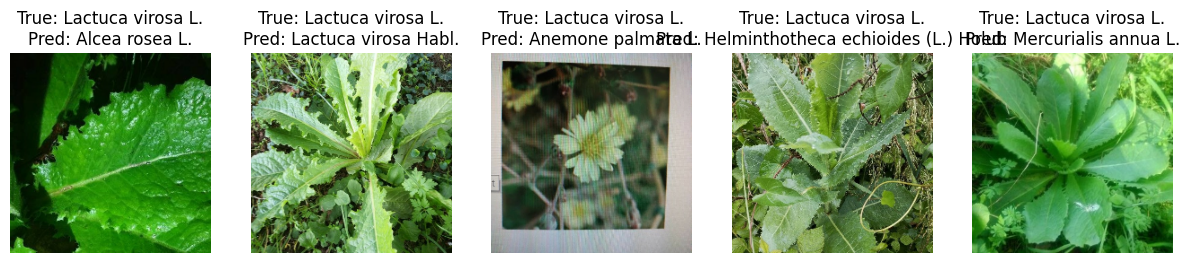

In [23]:
# Collect misclassified examples
misclassified_images = []
misclassified_true = []
misclassified_pred = []

for images, labels in test_dataset:
	preds = model.predict(images)
	preds = np.argmax(preds, axis=1)
	true = np.argmax(labels.numpy(), axis=1)
	for img, t, p in zip(images, true, preds):
		if t != p:
			misclassified_images.append(img.numpy())
			misclassified_true.append(t)
			misclassified_pred.append(p)
		if len(misclassified_images) >= 5:
			break
		if len(misclassified_images) >= 5:
			break

# Plot misclassified images
plot_misclassified(
	misclassified_images,
	misclassified_true,
	misclassified_pred,
	list(plantnet300K_names.values()),
	num=5
)


In [ ]:
# Save the model
model.save('efficientnet_plant_classifier.h5')